In [1]:
import torch
import numpy as np
import normflows as nf

seed=42
torch.manual_seed(seed)
torch.no_grad()

import sys
import os
c_directory = os.getcwd()
sys.path.append(os.path.join(c_directory, 'BSCD'))
sys.path.append(os.path.join(c_directory, 'FCYeast'))
sys.path.append(os.path.join(c_directory, 'FCYeast3'))

from matplotlib import pyplot as plt
import FC3_simulator

enable_cuda = True
CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
target = FC3_simulator.target()
context_size = 6

latent_size = 1
hidden_units = 128
hidden_layers = 5

/home/pessoa/Codes/SBIFC-inference/FCYeast3/FC3_simulator.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))
/home/pessoa/Codes/SBIFC-inference/FCYeast3/FC3_simulator.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params_dist = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))


In [3]:
dils_str = ['12','23','33']
dils = [.12,.23,.33]
models=[]

for dil in dils_str:
    flows = [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 64,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 128,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 256,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),      
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 512,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size)
         ]
    model_file = c_directory+'/FCYeast3/dilution{}/FCYeast_network.pt'.format(dil)
    q0 = nf.distributions.DiagGaussian(1)
    model = nf.ConditionalNormalizingFlow(q0, flows, target)
    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.load_state_dict(torch.load(model_file))
    models.append(model)

In [4]:
import pandas as pd

dils = [.12,.23,.33]

dfs = [pd.read_csv('clean_data/complete_d={}.csv'.format(d)) for d in dils]
x = [torch.tensor(df['FL1-A'].to_numpy().astype(np.float32)).reshape(-1,1).to(device) for df in dfs]


ind = torch.arange(0,x[0].size(0),10)
#if seed==42:
#    ind = torch.arange(0,x[0].size(0),10)
#else:
#    M = min([xi.size(0) for xi in x])
#    ind = torch.randperm(M)[:M//10]
#    ind = torch.sort(ind).values

x = [torch.log(xi[ind]) for xi in x]

In [5]:
def separate(x):
    return torch.tensor(((x[0],x[1],x[2],x[3],x[4],x[11]),
                         (x[0],x[1],x[5],x[6],x[7],x[11]),
                         (x[0],x[1],x[8],x[9],x[10],x[11]))).to(device)

to_hours = -torch.tensor(((0,0,-1,-1,1,0),
                         (0,0,-1,-1,1,0),
                         (0,0,-1,-1,1,0)),device=device)*torch.log(torch.tensor(dils)).reshape(-1,1).to(device)

def transform_to_hour(x): #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all in hours
    return separate(x) + to_hours


to_arbitrary = -torch.tensor(((1,1, 0, 0,0,0),
                             (1,1, 0, 0,0,0),
                             (1,1, 0, 0,0,0)),device=device)*torch.log(torch.tensor(dils)).reshape(-1,1).to(device)

def transform_to_arbitrary(x):  #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all to arbitrary
    return separate(x) + to_arbitrary
    

In [6]:
def logprior(params):
    return target.prior.log_prob(params)

vectorize_params = [torch.ones(xi.size(0),6).to(device) for xi in x]

def log_likelihood(data,params,models):
    global vectorize_params

    lp = []
    for (data_sub,params_sub,vec_params_sub,model_sub) in zip(data,params,vectorize_params,models):
        if data_sub.size !=  vec_params_sub.size(0):
            vec_params_sub = torch.ones((data_sub.size(0),6),device=device)
        lp.append(model_sub.log_prob(data_sub,params_sub*vec_params_sub))

    return lp

def log_post(data,params,models,lprior=logprior):
    return sum([lp.sum() for lp in log_likelihood(data,transform_to_arbitrary(params),models)]) + lprior(params)

In [7]:
params_100 = target.prior.sample((1000,))
params_100[:,0] -=1.
best_param = params_100[0]
lp_max = log_post(x,best_param,models)

for par in params_100[1:]:
    lp_par = log_post(x,par,models)
    if lp_par>lp_max:
        best_param = par
        lp_max=lp_par
        print(best_param,lp_max)

for i in range(3,10):
    print(i)
    for par in (1/i)*(params_100-best_param) + best_param:
        lp_par = log_post(x,par,models)
        if lp_par>lp_max:
            best_param = par
            lp_max=lp_par
            print(best_param,lp_max)


del params_100

tensor([ 0.1740,  3.8400,  2.3551, -0.6924, -2.2081, -1.1835, -1.8029, -3.0904,
         0.8387,  1.4192, -1.9765,  0.8505], device='cuda:0') tensor(-156474.9688, device='cuda:0')
tensor([ 0.1653,  4.4742, -0.8776,  0.3938, -2.2180, -0.1977,  1.0104, -2.9741,
        -0.3498, -0.6443, -2.0766, -1.0742], device='cuda:0') tensor(-75535.6484, device='cuda:0')
tensor([-0.1561,  5.7600, -0.6073,  0.3023, -2.9719, -0.3185,  0.5932, -2.0139,
        -0.7558, -0.1266, -2.5161, -2.7887], device='cuda:0') tensor(-64904.6133, device='cuda:0')
tensor([-0.1642,  4.5073, -1.0943, -0.2626, -1.6762, -1.5480,  0.1227, -2.4898,
        -0.6457,  0.3610, -2.7516, -0.7247], device='cuda:0') tensor(-63145.1914, device='cuda:0')
tensor([-0.6676,  5.0281,  0.4049,  1.1229, -2.8298, -1.7907,  0.4040, -2.3406,
        -1.2426,  0.8103, -1.9268, -0.7876], device='cuda:0') tensor(-61448.0820, device='cuda:0')
tensor([ 0.6479,  5.9954, -0.9695, -0.3457, -2.5583, -2.9816,  0.1421, -2.6527,
        -1.4119,  1.3701

In [8]:
param = best_param
lp = lp_max

sampled_params = [param.cpu()]
sampled_logpost = [lp.cpu().item()]

In [9]:
S = torch.eye(12)*1e-4
mvn = torch.distributions.MultivariateNormal(torch.zeros(12,device=device),S.to(device))

def change_S(newS):
    global S
    global mvn

    S = newS
    mvn = torch.distributions.MultivariateNormal(torch.zeros(12,device=device),S.to(device))

def proposal(param):
    return param + mvn.sample()

In [10]:
count_of_safe=0
loopruns = 0

while count_of_safe <=15:
    for i in range(150):
        param_prop = proposal(param)
        lp_prop = log_post(x,param_prop,models)

        if torch.log(torch.rand(1))< (lp_prop-lp).item():
            param = param_prop
            lp = lp_prop

        sampled_params.append(param.cpu())
        sampled_logpost.append(lp.cpu().item())

        #print(param_prop)

    acc_rate = np.mean([(sampled_params[i] - sampled_params[i-1]).sum().item()!=0 for i in range(-1,-101,-1)])

    if acc_rate>.2 and acc_rate<.5:
        count_of_safe += 1
    else:
        count_of_safe = 0

    if loopruns%3==2:
        change_S( (torch.stack(sampled_params[-200:]).T.cov() + torch.eye(12)*1e-8) * (2.4**2/(12)) )
    loopruns+=1

    print(loopruns,acc_rate, '    ', sampled_logpost[-1])
    



1 0.48      -44318.015625
2 0.46      -42873.82421875
3 0.38      -42293.05859375
4 0.08      -42038.85546875
5 0.18      -41620.55859375
6 0.06      -41600.22265625
7 0.19      -41588.8828125
8 0.23      -41584.6015625
9 0.16      -41571.76953125
10 0.37      -41565.640625
11 0.41      -41563.6328125
12 0.22      -41563.5703125
13 0.38      -41559.60546875
14 0.44      -41557.25
15 0.35      -41558.8046875
16 0.49      -41557.046875
17 0.29      -41561.08203125
18 0.55      -41557.4296875
19 0.48      -41557.515625
20 0.45      -41558.8046875
21 0.35      -41556.765625
22 0.31      -41556.83203125
23 0.44      -41555.69140625
24 0.44      -41557.625
25 0.28      -41553.3984375
26 0.23      -41554.5625
27 0.37      -41551.69921875
28 0.42      -41549.046875
29 0.4      -41551.55859375
30 0.45      -41554.1875
31 0.31      -41553.62109375
32 0.49      -41560.4609375
33 0.24      -41549.0
34 0.38      -41546.328125


In [11]:
burnin = len(sampled_logpost)
for i in range(100000):
    param_prop = proposal(param)
    lp_prop = log_post(x,param_prop,models)

    if torch.log(torch.rand(1))< (lp_prop-lp).item():
        param = param_prop
        lp = lp_prop

    sampled_params.append(param.cpu())
    sampled_logpost.append(lp.cpu().item())

    if i%100 == 99:
        print(i,param,lp)
        #print(i,param,lp)

99 tensor([ 0.3863,  6.0711, -0.3499,  1.2315, -2.5949, -2.4138,  0.3086, -1.5351,
        -3.2787,  1.2919, -1.6658, -2.4159], device='cuda:0') tensor(-41549.4375, device='cuda:0')
199 tensor([ 0.3712,  6.0839, -0.3425,  1.2318, -2.5849, -2.3997,  0.2950, -1.5274,
        -3.2735,  1.2897, -1.6464, -2.4303], device='cuda:0') tensor(-41545.6719, device='cuda:0')
299 tensor([ 0.3718,  6.0729, -0.3278,  1.2495, -2.5834, -2.3896,  0.3022, -1.5345,
        -3.2611,  1.2989, -1.6588, -2.4246], device='cuda:0') tensor(-41545.5156, device='cuda:0')
399 tensor([ 0.3695,  6.0680, -0.3183,  1.2451, -2.5965, -2.4031,  0.3056, -1.5393,
        -3.2573,  1.2869, -1.6639, -2.4154], device='cuda:0') tensor(-41548.9062, device='cuda:0')
499 tensor([ 0.3640,  6.0699, -0.3090,  1.2497, -2.5643, -2.3855,  0.2958, -1.5236,
        -3.2534,  1.2902, -1.6471, -2.4331], device='cuda:0') tensor(-41544.0898, device='cuda:0')
599 tensor([ 0.3649,  6.0654, -0.3334,  1.2311, -2.5614, -2.3916,  0.2896, -1.5250,
  

In [12]:
np.savetxt('mcmc_real_results_{}seed.csv'.format(seed),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))

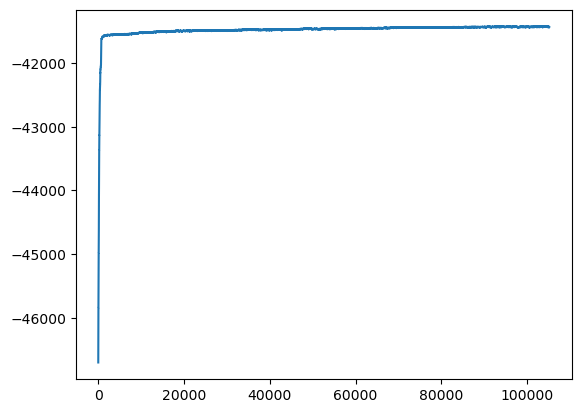

In [13]:
plt.plot(sampled_logpost)

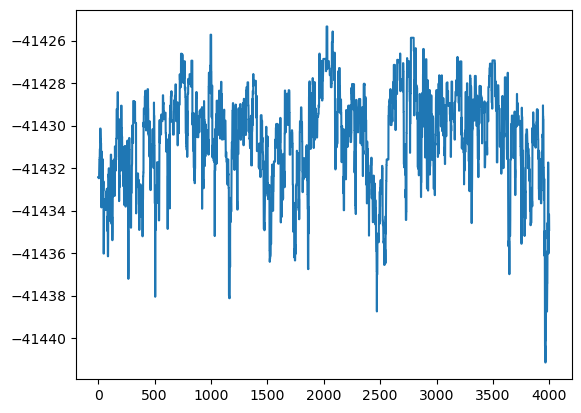

In [14]:
plt.plot(sampled_logpost[-4000:])

In [15]:

def grid_plot(x,param,model):
    xp = torch.linspace(x.min(),x.max(),101).to(device)
    lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,6),device=device)*param)
    p = torch.exp(lp-lp.max())
    p *= 1/(p.sum()*(xp[1]-xp[0]))
    return xp.cpu(),p.cpu()




In [16]:
best_param = sampled_params[np.argmax(sampled_logpost)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


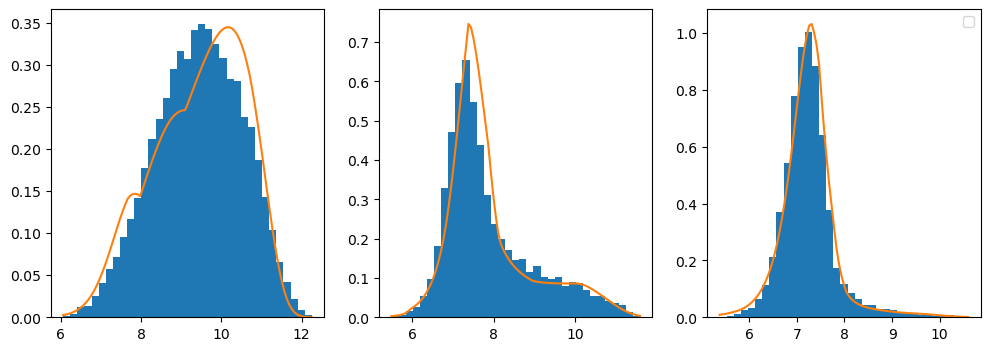

In [17]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x)]
params = transform_to_arbitrary(best_param)
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi,model) in zip(x,params,ax,models)]
#[axi.hist(model.sample((10000,),parami),density=True,alpha=.4) for (xi,parami,axi,model) in zip(x,params,ax,models)]


plt.legend()

In [18]:
import FCYeast.FCYeast_simulator 
target = FCYeast.FCYeast_simulator.target()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


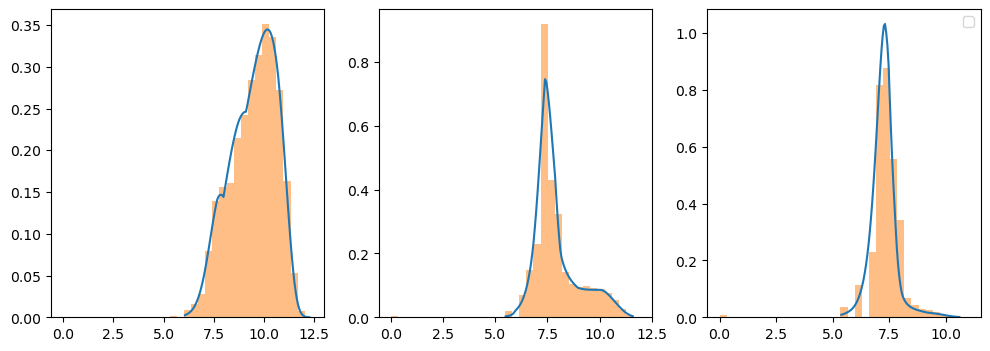

In [19]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
#[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x)]

params = transform_to_arbitrary(best_param)
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi,model) in zip(x,params,ax,models)]
#[axi.hist(model.sample((10000,),parami),density=True,alpha=.4) for (xi,parami,axi,model) in zip(x,params,ax,models)]

[ax[i].hist(target.sample(params[i,:2],params[i,2:4],params[i,4:5],params[i,5:],n=2**16,return_lparams=False).cpu().numpy(),
          density=True,
          bins=35,alpha=.5) for i in range(3)]


plt.legend()

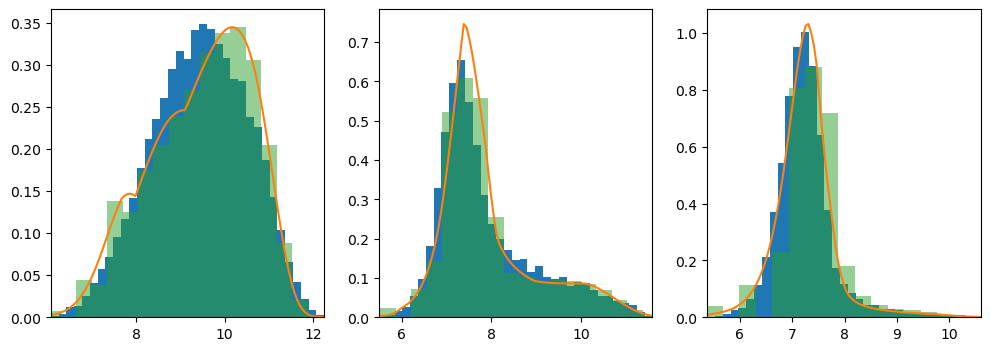

In [20]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x)]
params = transform_to_arbitrary(best_param)
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi,model) in zip(x,params,ax,models)]
[ax[i].hist(target.sample(params[i,:2],params[i,2:4],params[i,4:5],params[i,5:],n=2**16,return_lparams=False).cpu().numpy(),
          density=True,
          bins=35,alpha=.5) for i in range(3)]
[axi.set_xlim(xi.cpu().min(),xi.cpu().max()) for  (axi,xi) in zip(ax,x)]

plt.savefig('mcmc_check_{}seed.png'.format(seed),dpi=600)

In [21]:
torch.log(torch.tensor(dils))

tensor([-2.1203, -1.4697, -1.1087])